# UCI Heart Disease Dataset: Population Analysis & Data Quality Strategy


<a id="toc"></a>
## Table of Contents
1. [Introduction](#introduction)
2. [Setup & Data Loading](#setup-data-loading)
3. [Population Overview](#population-overview)
4. [Variable Distribution Comparisons](#variable-distribution)
5. [Target Variable by Population](#target-variably-analysis)
6. [Pooling Decision](#pooling-decision)
7. [Missing Data Decision](#missing-data-decision)
8. [Data Cleaning Implementation](#data-cleaning-implementation)
9. [Conclusions & Prepared Dataset](#conclusions-and-dataset)



<a id='introduction'></a>
## Introduction

### Context
In Notebook 1, we identified that **67.4%** of cases were incomplete (missing at least one value) across *potentially* important variables, with patterns strongly suggesting population-level differences.

Before proceeding with modeling, we need to understand whether the four populations (Cleveland, Hungarian, Switzerland, VA Long Beach) can be reasonably pooled together or should be treated separately (or partially pooled).

### Objective
This notebook compares the four populations to:
- Describe sample sizes and baseline characteristics.
- Test whether populations differ materially on key variables.
- Make a principled recommendation about pooling vs separate analysis.
- Propose a missing-data handling strategy per variable (overall and by population).

### Research Questions
1. What are the sample sizes and characteristics of each population?
2. How do missing data patterns differ across populations?
3. Are the populations statistically comparable on key variables?
4. Should we pool populations or analyze them separately?
5. What is the appropriate strategy for handling missing data in each variable?

### Notes / Assumptions
- The four datasets represent different clinical sites and data collection protocols; we expect systematic differences.
- Encodings follow the standard UCI Heart Disease documentation (we will flag out-of-domain values rather than auto-correct).
- For comparability tests, we test distributions on observed values; missingness itself is analyzed separately.


<a id='setup-and-data-loading'></a>
## Setup & Data Loading
- Import libraries
- Load data (reference to Notebook 1)
- Create population indicator variable

### Data Loading Notes
We load the combined dataframe created in `load_datasets.py` and standardize types.
Domain cleaning rules used for analysis:
- `Chol == 0` is treated as missing
- `Rest BP == 0` is treated as missing
- `Oldpeak < 0` is treated as missing


In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Statistical utilities
from scipy.stats import chi2_contingency, kruskal

# Setting up general plot styles
from utils.data_visualizations import setup_plot_style
setup_plot_style()

# Utility functions used throughout
from utils.data_quality import calculate_missingness_summary

# Display dataframe numerical values up to 2 decimal points
pd.options.display.float_format = "{:,.2f}".format

warnings.filterwarnings('ignore')


In [2]:
from load_datasets import dfs, df_combined

df = df_combined.copy()

pop_order = ["Cleveland", "Hungarian", "Switzerland", "VA Long Beach"]

numeric_cols = ["Age", "Rest BP", "Chol", "Max HR", "Oldpeak", "CVD Class"]
categorical_cols = ["Sex", "Chest Pain", "FBS", "Rest ECG", "Ex Angina", "Slope", "Ca", "Thal"]

for col in numeric_cols + categorical_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Domain cleaning for analysis
df_analysis = df.copy()
df_analysis.loc[df_analysis["Chol"] == 0, "Chol"] = np.nan
df_analysis.loc[df_analysis["Rest BP"] == 0, "Rest BP"] = np.nan
df_analysis.loc[df_analysis["Oldpeak"] < 0, "Oldpeak"] = np.nan

df_analysis.head()


,Age,Sex,Chest Pain,Rest BP,Chol,FBS,Rest ECG,Max HR,Ex Angina,Oldpeak,Slope,Ca,Thal,CVD Class,Dataset
0,67.00,1.00,4.00,160.00,286.00,0.00,2.00,108.00,1.00,1.50,2.00,3.00,3.00,2,Cleveland
1,67.00,1.00,4.00,120.00,229.00,0.00,2.00,129.00,1.00,2.60,2.00,2.00,7.00,1,Cleveland
2,37.00,1.00,3.00,130.00,250.00,0.00,0.00,187.00,0.00,3.50,3.00,0.00,3.00,0,Cleveland
3,41.00,0.00,2.00,130.00,204.00,0.00,2.00,172.00,0.00,1.40,1.00,0.00,3.00,0,Cleveland
4,56.00,1.00,2.00,120.00,236.00,0.00,0.00,178.00,0.00,0.80,1.00,0.00,3.00,0,Cleveland


<a id='population-overview'></a>
## Population Overview
- Sample size per population
- Target variable distribution by population
- Initial comparison of class balance

In [3]:
population_rows = []
for name in pop_order:
    subset = df_analysis[df_analysis["Dataset"] == name]
    population_rows.append({
        "Dataset": name,
        "N": len(subset),
        "% Male": round((subset["Sex"] == 1).mean() * 100, 1),
        "Age Mean (SD)": f"{subset['Age'].mean():.1f} ({subset['Age'].std():.1f})",
        "CVD Prev % (1+)": round((subset["CVD Class"] > 0).mean() * 100, 1),
        "Missing Cells %": round(subset.isna().sum().sum() / subset.size * 100, 1),
        "Complete Cases %": round((~subset.isna().any(axis=1)).mean() * 100, 1),
    })

population_summary = pd.DataFrame(population_rows)
population_summary


,Dataset,N,% Male,Age Mean (SD),CVD Prev % (1+),Missing Cells %,Complete Cases %
0,Cleveland,302,67.90,54.4 (9.0),46.00,0.10,98.00
1,Hungarian,293,72.40,47.9 (7.7),36.20,17.70,0.30
2,Switzerland,122,91.80,55.5 (8.8),93.40,22.00,0.00
3,VA Long Beach,199,97.00,59.3 (7.8),74.40,25.00,0.50


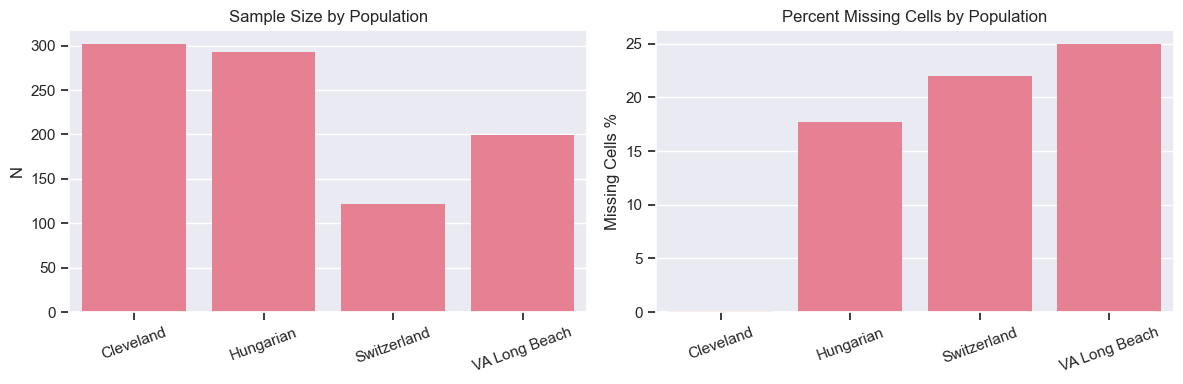

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=population_summary, x="Dataset", y="N", order=pop_order, ax=axes[0])
axes[0].set_title("Sample Size by Population")
axes[0].set_xlabel("")
axes[0].tick_params(axis="x", rotation=20)

sns.barplot(data=population_summary, x="Dataset", y="Missing Cells %", order=pop_order, ax=axes[1])
axes[1].set_title("Percent Missing Cells by Population")
axes[1].set_xlabel("")
axes[1].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()


Key takeaways:
- Cleveland is nearly complete and has the most balanced prevalence.
- Hungarian is younger on average and has substantial missingness concentrated in specific variables.
- Switzerland and VA Long Beach are heavily male and have much higher disease prevalence.


<a id='variable-distribution-comparisons'></a>
## Variable Distribution Comparisons
- For each key variable:
- Descriptive statistics by population
- Visualization (box plots, histograms)
- Statistical tests (ANOVA, Chi-square as appropriate)
- Identify which variables are consistent vs. population-specific

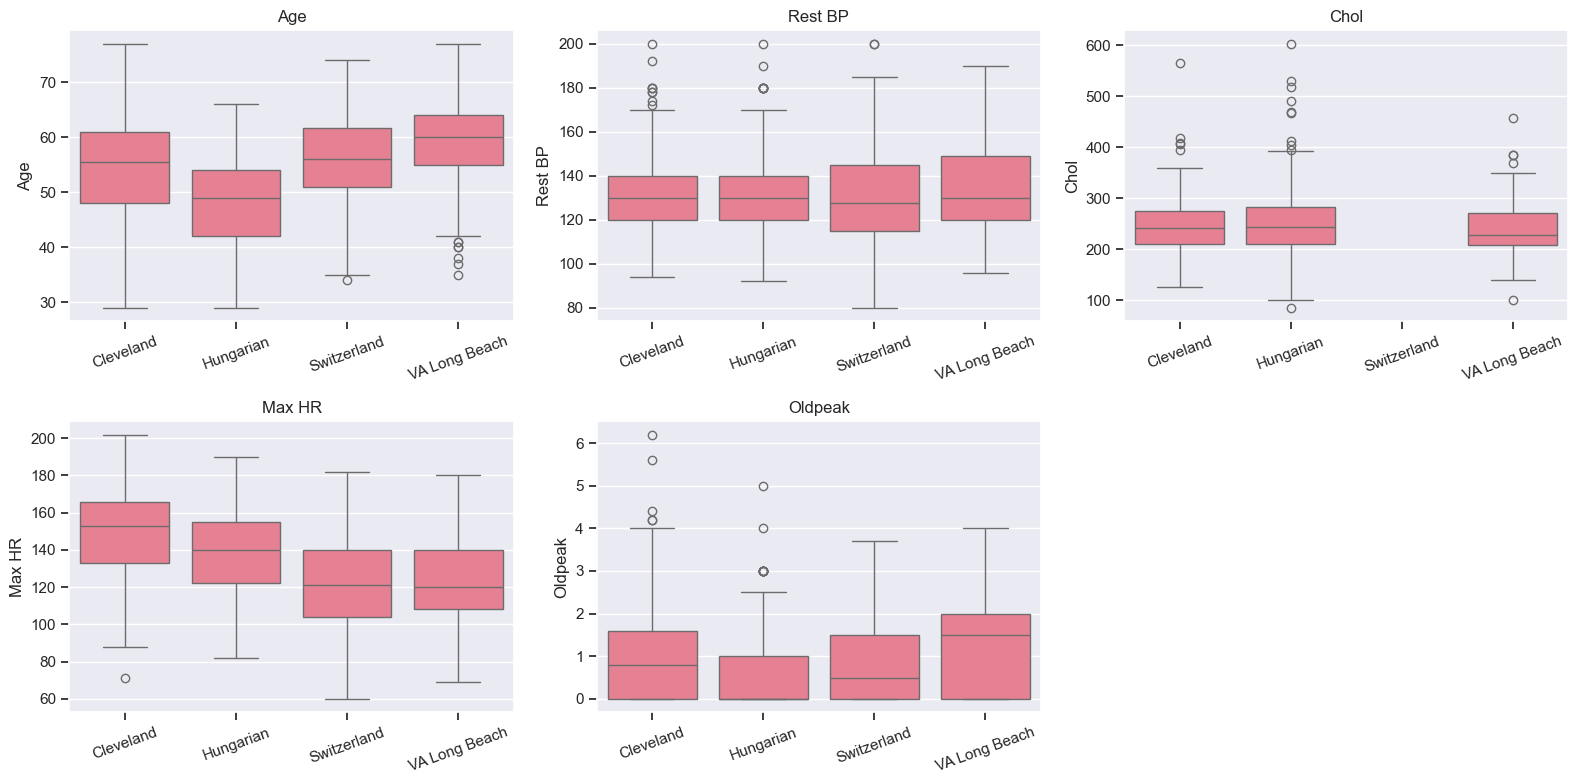

In [5]:
numeric_plot_cols = ["Age", "Rest BP", "Chol", "Max HR", "Oldpeak"]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for ax, col in zip(axes, numeric_plot_cols):
    sns.boxplot(data=df_analysis, x="Dataset", y=col, order=pop_order, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=20)

for ax in axes[len(numeric_plot_cols):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


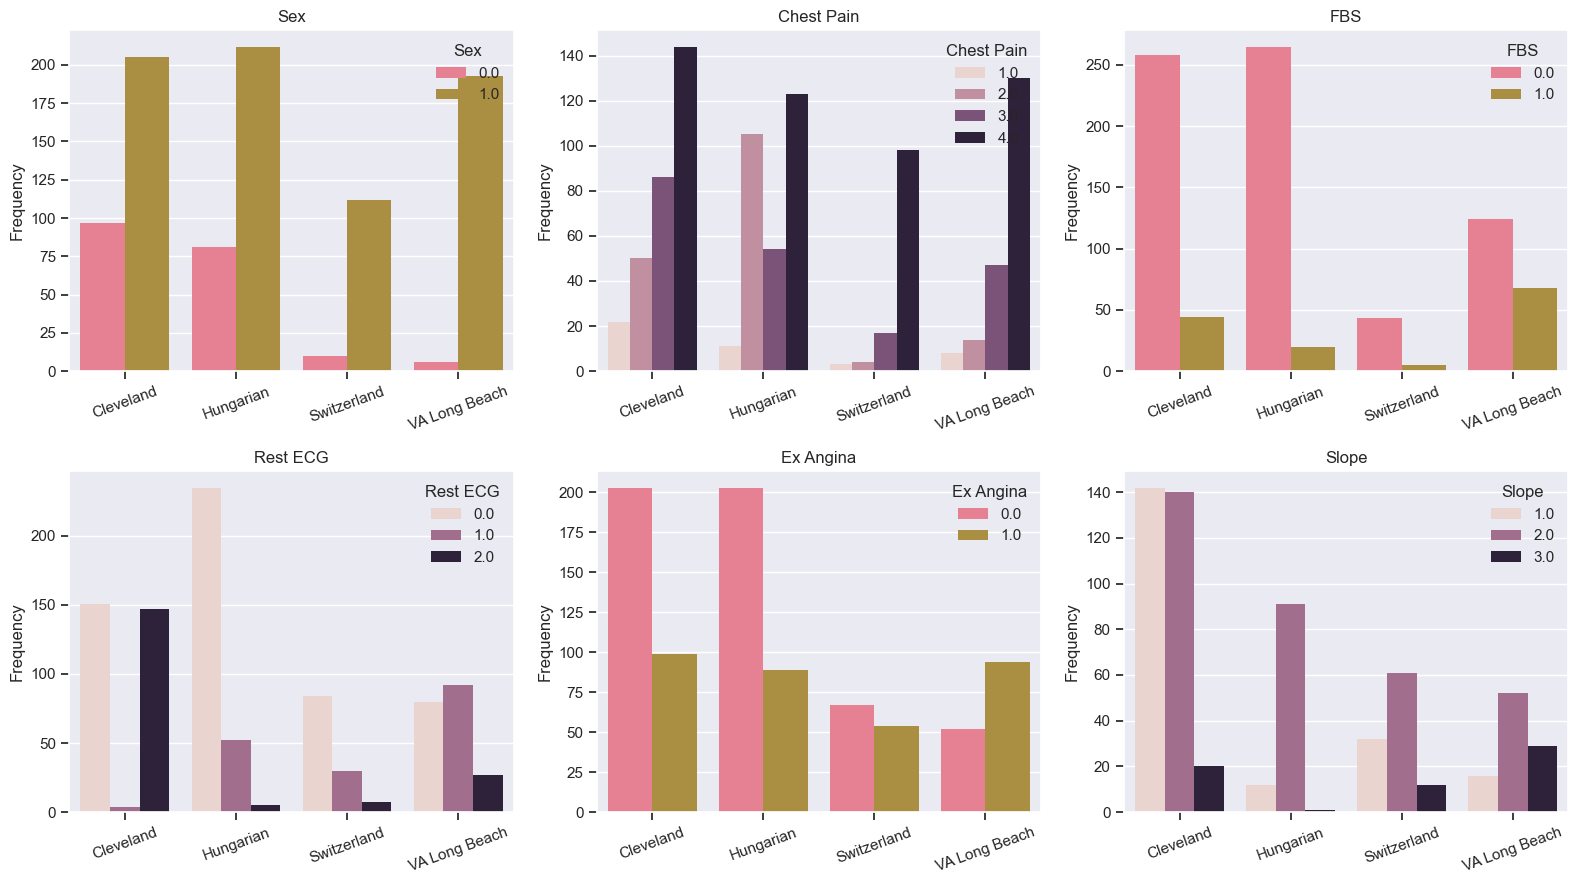

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):
    sns.countplot(data=df_analysis, x="Dataset", hue=col, order=pop_order, orient='h', ax=ax)
    ax.set_title(col)
    ax.set_ylabel("Frequency")
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()



In [30]:
test_results = []

for col in numeric_plot_cols:
    groups = [
        df_analysis.loc[df_analysis["Dataset"] == name, col].dropna().values
        for name in pop_order
    ]
    if all(len(g) > 1 for g in groups):
        stat, p = kruskal(*groups)
        test_results.append({"Variable": col, "Test": "Kruskal-Wallis", "p_value": p})

for col in categorical_cols:
    table = pd.crosstab(df_analysis["Dataset"], df_analysis[col])
    if table.shape[1] > 1:
        chi2, p, dof, exp = chi2_contingency(table)
        test_results.append({"Variable": col, "Test": "Chi-square", "p_value": p})

# Target distribution test
ct_table = pd.crosstab(df_analysis["Dataset"], df_analysis["CVD Class"])
chi2, p, dof, exp = chi2_contingency(ct_table)
test_results.append({"Variable": "CVD Class", "Test": "Chi-square", "p_value": p})

test_results_df = pd.DataFrame(test_results).sort_values("p_value")
test_results_df["p_value"] = test_results_df["p_value"].map(lambda x: f"{x:.2e}")
test_results_df


,Variable,Test,p_value
7,Rest ECG,Chi-square,4.38e-73
12,CVD Class,Chi-square,1.19e-47
0,Age,Kruskal-Wallis,2.83e-43
2,Max HR,Kruskal-Wallis,1.68e-34
5,Chest Pain,Chi-square,2.29e-22
9,Slope,Chi-square,4.09e-22
4,Sex,Chi-square,2.24e-17
6,FBS,Chi-square,3.60e-15
3,Oldpeak,Kruskal-Wallis,2.70e-14
8,Ex Angina,Chi-square,7.00e-12


<a id='target-variable-analysis-by-population'></a>
## Target Variable Analysis by Population
- Heart disease prevalence and severity by location
- Statistical significance of differences
- Clinical interpretation of differences

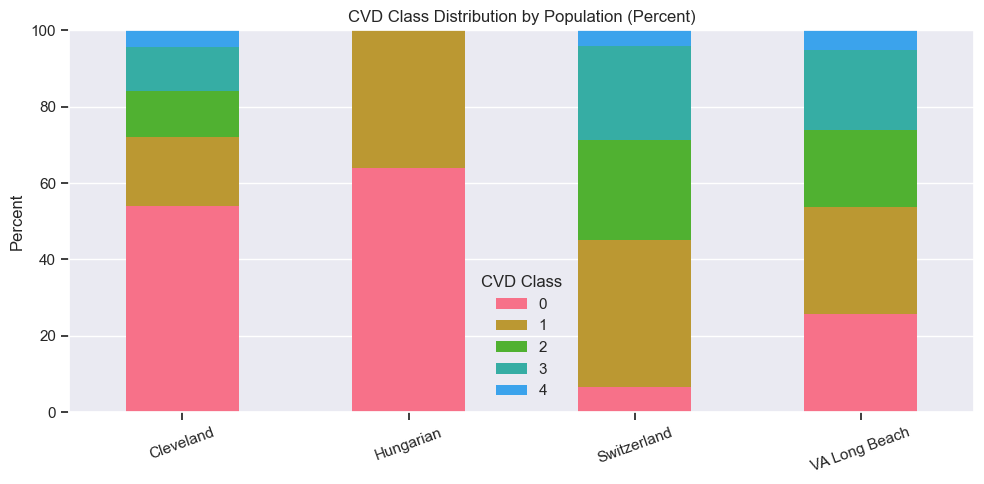

In [ ]:
severity_dist = pd.crosstab(
    df_analysis["Dataset"],
    df_analysis["CVD Class"],
    normalize="index"
) * 100
severity_dist = severity_dist.reindex(pop_order)

severity_dist.plot(kind="bar", stacked=True, figsize=(10, 5))
plt.title("CVD Class Distribution by Population (Percent)")
plt.xlabel("")
plt.ylabel("Percent")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


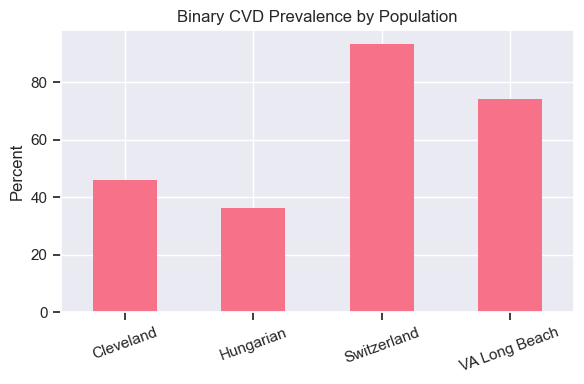

Chi-square p-value for binary target by population: 2.23e-33


In [9]:
df_analysis["CVD Binary"] = (df_analysis["CVD Class"] > 0).astype(int)

binary_prev = df_analysis.groupby("Dataset")["CVD Binary"].mean() * 100
binary_prev = binary_prev.reindex(pop_order)

binary_prev.plot(kind="bar", figsize=(6, 4))
plt.title("Binary CVD Prevalence by Population")
plt.xlabel("")
plt.ylabel("Percent")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

binary_table = pd.crosstab(df_analysis["Dataset"], df_analysis["CVD Binary"])
chi2, p, dof, exp = chi2_contingency(binary_table)
print(f"Chi-square p-value for binary target by population: {p:.2e}")


<a id='pooling-decision'></a>
## Pooling Decision
- Evidence for/against pooling populations
- Final decision with justification
- Implications for modeling

Pooling decision summary:
- Most variables differ significantly by population (Kruskal or Chi-square tests show p < 0.001 for age, max heart rate, oldpeak, sex, chest pain, FBS, rest ECG, ex angina, slope, thal, and target class).
- Missingness is strongly site-dependent for key features (Ca, Thal, Slope, Chol, and several vital signs), which indicates NMAR or structural missingness.
- Target prevalence varies widely by site, and the Hungarian dataset only has classes 0 and 1. This makes ordinal target modeling across all populations inconsistent.

Pooling implementation:

This will be a bit more interesting. Given that certain variables are practically non-existent in specific datasets, we'll have to adjust our strategy for those. I decided that I do not want to remove any data unless absolutely necessary, so imputation will be the go-to method. Since this is medical data, and each feature can potentially reveal an unexplained factor behind CVD, we want to keep everything we have, and use an appropriate method for imputation. 

For example, the Ca and Thal variables show almost full missingness across all datasets except Cleveland. This is a problem.

<a id='misising-data-decicion'></a>
## Missing Data Decision
- For each variable with missing data:
- Assess missingness mechanism (MCAR/MAR/MNAR)
- Proportion missing (overall and by population)
- Decision: Drop, impute, or create indicator
- Justification for decision

In [10]:
missing_by_dataset = df_analysis.groupby("Dataset").apply(lambda x: x.isna().mean() * 100)
missing_by_dataset = missing_by_dataset.loc[:, missing_by_dataset.max() > 0]
missing_by_dataset = missing_by_dataset.reindex(pop_order)
missing_by_dataset.round(1)


,Rest BP,Chol,FBS,Rest ECG,Max HR,Ex Angina,Oldpeak,Slope,Ca,Thal
Dataset,,,,,,,,,,
Cleveland,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.30,0.70
Hungarian,0.30,7.80,2.70,0.30,0.30,0.30,0.00,64.50,99.00,90.40
Switzerland,1.60,100.00,60.70,0.80,0.80,0.80,13.90,13.90,95.90,41.80
VA Long Beach,28.60,28.10,3.50,0.00,26.60,26.60,28.60,51.30,99.00,82.90


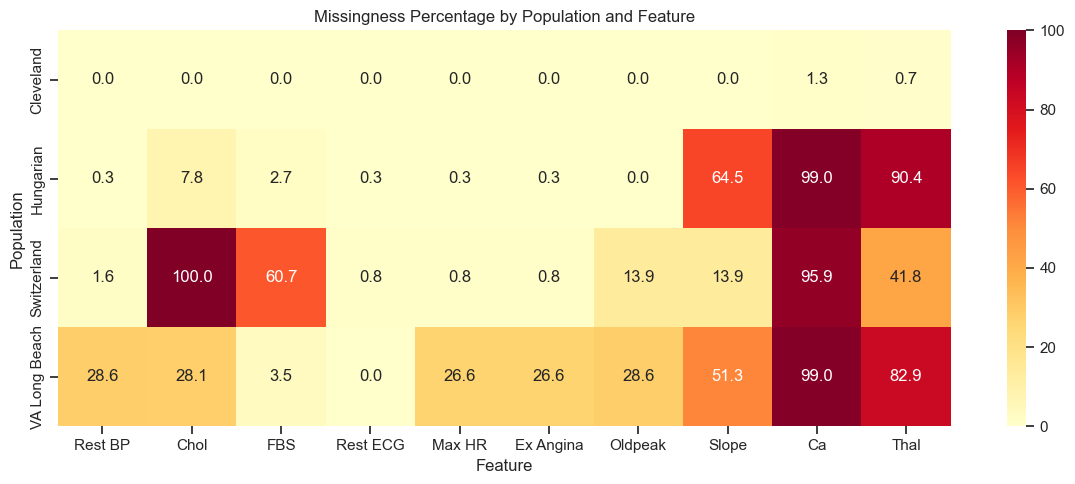

In [11]:
plt.figure(figsize=(12, 5))
sns.heatmap(missing_by_dataset, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Missingness Percentage by Population and Feature")
plt.xlabel("Feature")
plt.ylabel("Population")
plt.tight_layout()
plt.show()


Missingness decisions are based on the following logic:
- If a feature is structurally missing in multiple populations, drop it from pooled modeling.
- If missingness is moderate and site-dependent, keep the feature with a missingness indicator and impute within each site.
- For invalid domain values, treat them as missing before imputation.

### 1. The Verdict on Ca and Thal

In the Hungarian, Swiss, and VA Long Beach sets, Ca and Thal are missing at rates of 82.9% to 99.0%.

- **The Problem**: When a variable is nearly 100% missing in a specific sub-population, imputation (like MICE or KNN) doesn't "fill in the blanks". It will instead clone the distribution of the Cleveland dataset onto the other populations which isn't good.

- **The Risk**: If the Ca and Thal variables are included in Factor Analysis, those variables will likely load heavily on a factor simply because they are correlated in the one dataset where they exist. This biases the underlying CVD factors toward the Cleveland clinical profile (essentially, the introduction of a Cleveland dataset-bias).

- **Decision**: I will exclude Ca and Thal from the global Factor Analysis. They are important clinical markers, but because they clearly weren't part of the standard diagnostic workflow across all sites, I can't do much but take a *heavily* biased guess for their values in non-Cleveland dataset patients.

### 2. Dealing with "The Middle Ground" (Slope, Chol, RestBP)

Variables like Slope (missing 64% in Hungary) and Chol (100% missing in Switzerland) will require a more nuanced approach.

Since Factor Analysis depends on the covariance matrix, having 100% missingness in one dataset (Chol in Switzerland) will break the ability to calculate a unified covariance.

    Primary Analysis: Run your FA using only the "Common Core" variables (Age, Sex, Chest Pain Type, RestBP, MaxHR, ExAngina, Oldpeak, ECG). These are relatively complete across the board.

    Secondary Analysis: Perform a "High-Resolution" FA on just the Cleveland and VA datasets where more clinical markers were recorded. Compare the factor structures. If the "Core" factors remain stable, you’ve found your universal drivers.

<a id='summary-table'></a>
## Summary table of all decisions
- Data Cleaning Implementation
- Apply missing data strategy
- Create cleaned dataset
- Document transformations
- Final dataset summary


In [ ]:
features = [
    "Age", "Sex", "Chest Pain", "Rest BP", "Chol", "FBS", "Rest ECG", "Max HR",
    "Ex Angina", "Oldpeak", "Slope", "Ca", "Thal", "CVD Class"
]

missing_overall = df_analysis[features].isna().mean() * 100
missing_by_dataset = df_analysis.groupby("Dataset")[features].apply(lambda x: x.isna().mean() * 100)
missing_by_dataset = missing_by_dataset.reindex(pop_order)

mechanism_map = {
    "Age": "Complete",
    "Sex": "Complete",
    "Chest Pain": "Complete",
    "Rest BP": "Site-dependent (VA high; 0-coded values)",
    "Chol": "Structural in Switzerland (0-coded values)",
    "FBS": "Site-dependent (Swiss high)",
    "Rest ECG": "Low missingness",
    "Max HR": "Site-dependent (VA high)",
    "Ex Angina": "Site-dependent (VA high)",
    "Oldpeak": "Site-dependent; negative values",
    "Slope": "Structural (Hungarian and VA high)",
    "Ca": "Structural (Hungarian/VA/Swiss high)",
    "Thal": "Structural (Hungarian/VA high)",
    "CVD Class": "Observed"
}

decision_map = {
    "Age": "Keep",
    "Sex": "Keep",
    "Chest Pain": "Keep",
    "Rest BP": "Keep + indicator + median impute",
    "Chol": "TBD",
    "FBS": "TBD",
    "Rest ECG": "Keep",
    "Max HR": "Keep + indicator + median impute",
    "Ex Angina": "Keep + indicator + mode impute",
    "Oldpeak": "Keep + indicator + median impute",
    "Slope": "Drop from pooled; keep for Cleveland-only",
    "Ca": "TBD",
    "Thal": "Drop from pooled; keep for Cleveland-only",
    "CVD Class": "Binarize for pooled; keep ordinal for Cleveland-only"
}

notes_map = {
    "Rest BP": "Treat 0 as missing",
    "Chol": "Treat 0 as missing",
    "Oldpeak": "Treat < 0 as missing"
}

rows = []
for feature in features:
    row = {
        "Feature": feature,
        "Missing Overall %": round(missing_overall[feature], 1),
        "Cleveland %": round(missing_by_dataset.loc["Cleveland", feature], 1),
        "Hungarian %": round(missing_by_dataset.loc["Hungarian", feature], 1),
        "Switzerland %": round(missing_by_dataset.loc["Switzerland", feature], 1),
        "VA Long Beach %": round(missing_by_dataset.loc["VA Long Beach", feature], 1),
        "Mechanism": mechanism_map.get(feature, ""),
        "Pooled Decision": decision_map.get(feature, ""),
        "Notes": notes_map.get(feature, "")
    }
    rows.append(row)

decision_table = pd.DataFrame(rows)
decision_table


,Feature,Missing Overall %,Cleveland %,Hungarian %,Switzerland %,VA Long Beach %,Mechanism,Pooled Decision,Notes
0,Age,0.00,0.00,0.00,0.00,0.00,Complete,Keep,
1,Sex,0.00,0.00,0.00,0.00,0.00,Complete,Keep,
2,Chest Pain,0.00,0.00,0.00,0.00,0.00,Complete,Keep,
3,Rest BP,6.60,0.00,0.30,1.60,28.60,Site-dependent (VA high; 0-coded values),Keep + indicator + median impute,Treat 0 as missing
4,Chol,21.90,0.00,7.80,100.00,28.10,Structural in Switzerland (0-coded values),Keep if excluding Switzerland; otherwise drop,Treat 0 as missing
5,FBS,9.70,0.00,2.70,60.70,3.50,Site-dependent (Swiss high),Keep if excluding Switzerland; otherwise drop,
6,Rest ECG,0.20,0.00,0.30,0.80,0.00,Low missingness,Keep,
7,Max HR,6.00,0.00,0.30,0.80,26.60,Site-dependent (VA high),Keep + indicator + median impute,
8,Ex Angina,6.00,0.00,0.30,0.80,26.60,Site-dependent (VA high),Keep + indicator + mode impute,
9,Oldpeak,8.10,0.00,0.00,13.90,28.60,Site-dependent; negative values,Keep + indicator + median impute,Treat < 0 as missing


In [ ]:
from utils.data_cleaning import add_missingness_indicators

# Helper for site-specific imputation
def impute_by_dataset(df_in, group_col, numeric_cols, categorical_cols):
    df_out = df_in.copy()
    for col in numeric_cols:
        df_out[col] = df_out.groupby(group_col)[col].transform(lambda s: s.fillna(s.median()))
    for col in categorical_cols:
        df_out[col] = df_out.groupby(group_col)[col].transform(lambda s: s.fillna(s.mode().iloc[0]))
    return df_out

# Primary pooled dataset: exclude Switzerland due to structural missingness
pooled_df = df_analysis.copy()
pooled_df["CVD Binary"] = (pooled_df["CVD Class"] > 0).astype(int)

# Add missingness indicators for moderate-missing features
missing_indicator_features = ["Rest BP", "Chol", "FBS", "Max HR", "Ex Angina", "Oldpeak"]
pooled_df = add_missingness_indicators(pooled_df, missing_indicator_features)

# Impute within site
numeric_impute_cols = ["Rest BP", "Chol", "Max HR", "Oldpeak"]
categorical_impute_cols = ["FBS", "Ex Angina", "Rest ECG"]
pooled_df = impute_by_dataset(
    pooled_df,
    group_col="Dataset",
    numeric_cols=numeric_impute_cols,
    categorical_cols=categorical_impute_cols
)

# Cleveland-only dataset
cleveland_df = df_analysis[df_analysis["Dataset"] == "Cleveland"].copy()
cleveland_df["CVD Binary"] = (cleveland_df["CVD Class"] > 0).astype(int)

cleveland_df = impute_by_dataset(
    cleveland_df,
    group_col="Dataset",
    numeric_cols=["Rest BP", "Chol", "Max HR", "Oldpeak"],
    categorical_cols=["FBS", "Ex Angina", "Rest ECG", "Ca", "Thal", "Slope"]
)

pooled_df.isna().mean().mul(100).round(2)


Age                 0.00
Sex                 0.00
Chest Pain          0.00
Rest BP             0.00
Chol                0.00
FBS                 0.00
Rest ECG            0.00
Max HR              0.00
Ex Angina           0.00
Oldpeak             0.00
CVD Class           0.00
Dataset             0.00
CVD Binary          0.00
Rest BP_missing     0.00
Chol_missing        0.00
FBS_missing         0.00
Max HR_missing      0.00
Ex Angina_missing   0.00
Oldpeak_missing     0.00
dtype: float64

In [ ]:
# Little quick experiment: Bin max HR by age, look at age differences 
age_series = df_combined['Age']
min_age, max_age = age_series.min(), age_series.max()
bins = [30, 40, 50, 60, 70, 80]
labels=["Thirties", "Fourties", "Fifties", "Sixties", "Seventies"]

df_numeric = df[numeric_cols]
df_numeric['Age Category'] = pd.cut(x=age_series, bins=bins, labels=labels)

age_groups = df_numeric.groupby(by='Age Category').aggregate('mean')
age_groups

,Age,Rest BP,Chol,Max HR,Oldpeak,CVD Class
Age Category,,,,,,
Thirties,36.88,124.66,208.77,155.57,0.45,0.49
Fourties,45.67,127.99,216.14,144.96,0.61,0.60
Fifties,55.47,133.54,197.76,134.66,0.94,1.02
Sixties,64.25,137.60,179.85,126.13,1.27,1.57
Seventies,73.54,139.05,194.68,120.95,1.23,1.58


<Axes: xlabel='Max HR', ylabel='CVD Class'>

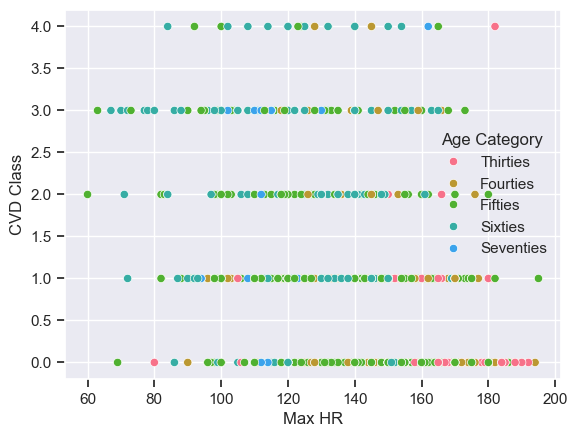

In [ ]:
sns.scatterplot(data=df_numeric, y='CVD Class', x='Max HR', hue='Age Category')
plt.yticks(ticks=np.arange(0, 4, step=1), labels=["No CVD", "Early CVD", "Advanced CVD", "Severe CVD"])
plt.show()

<a id='conclusions-and-prepared-dataset'></a>
## Conclusions & Prepared Dataset
- Summary of population analysis
- Summary of data cleaning decisions
- Description of final dataset
- Save cleaned data for next notebook

Summary:
- Population differences are large in demographics, target prevalence, and key clinical variables.
- Missingness is strongly tied to site, with Ca, Thal, and Slope essentially unavailable outside Cleveland.
- A primary pooled dataset should exclude Switzerland, use a binary target, include dataset as a covariate, and rely on missingness indicators with site-specific imputation.
- A Cleveland-only dataset can retain Ca, Thal, and Slope for a richer feature set.


In [15]:
# Save prepared datasets for downstream notebooks
pooled_df.to_csv("data/cleaned_pooled_no_swiss.csv", index=False)
cleveland_df.to_csv("data/cleaned_cleveland_full.csv", index=False)
